# Class Imbalance Problems - Lab

## Introduction


Now that we've discussed some techniques for tuning classifcation models on imbalanced datasets, its time to practice those techniques. In this lab you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:
* Use modified sampling techniques to address class imbalance problems
* Understand the complications of class imbalance problems

## Predicting Credit Card Fraud
Load the **creditcard.csv.gz** file and preview the data. To load a compressed csv use the optional parameter compression='gzip' within pandas read_csv method as in: `pd.read_csv(filename, compression='gzip')`.

In [31]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('creditcard.csv.gz', compression='gzip')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.400941e-16,-1.373150e-15,2.100041e-15,9.604066e-16,1.494099e-15,-5.556467e-16,1.213481e-16,-2.412044e-15,...,1.658558e-16,-3.444850e-16,2.642515e-16,4.473515e-15,5.340915e-16,1.686974e-15,-3.662461e-16,-1.222151e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Preview the class imbalance

You should see that the dataset has 31 columns. The first is a time field, followed by V1-V28; manual feature engineering done on the backend that we have little information about. Finally, we have the amount of the purchase and a binary Class flag. This last column, Class, is the indication of whether or not the purchase was fradulent, and is the feature we are attempting to predict.

Take a look at how imbalanced this dataset is.

In [9]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Define the Problem

Define X and y and perform a standard train test split.

In [11]:
X = df[df.columns[:-1]]
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [12]:
y_train.value_counts()

0    213233
1       372
Name: Class, dtype: int64

In [13]:
y_test.value_counts()

0    71082
1      120
Name: Class, dtype: int64

## Create an initial model

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

In [14]:
logreg = LogisticRegression(fit_intercept = False)

y_score = logreg.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
y_score.shape

(71202,)

In [22]:
fpr.shape

(314,)

In [23]:
tpr.shape

(314,)

In [24]:
thresholds.shape

(314,)

AUC: 0.8841414375885128


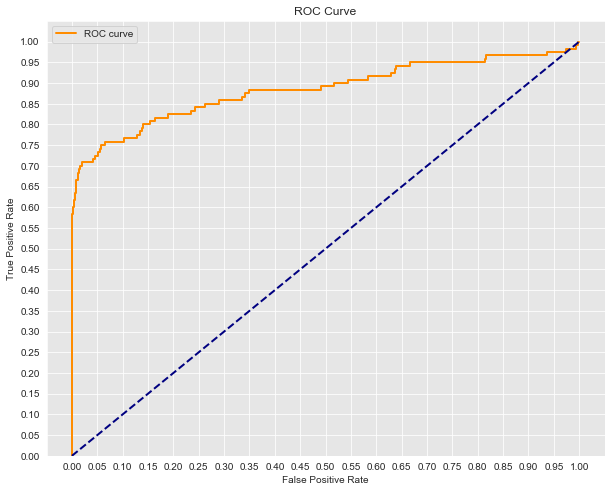

In [32]:
# use seaborn styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))

lw = 2

plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve')
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xticks([i/20 for i in range(21)])
plt.yticks([i/20 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()



In [33]:
# look at a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[71026    53]
 [   56    67]]


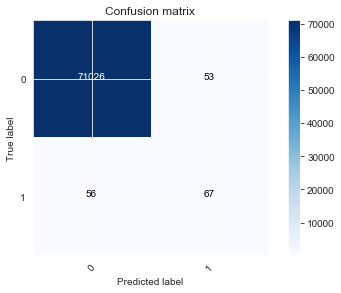

In [34]:
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Tuning 
Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.001: 0.8397641690817178


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.01: 0.8817812526377986


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.1: 0.8839373305947121


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1: 0.8841414375885128


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 10: 0.8841610159158905


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 100: 0.8841628916837829


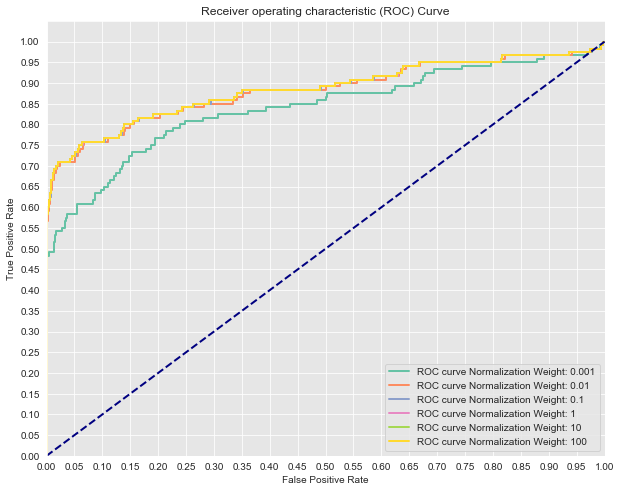

In [35]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")

### SMOTE
If you haven't already, try using the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.

In [37]:
#SMOTE = Synthetic Minority Oversampling
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)
pd.Series(y_train_resampled).value_counts()

1    213233
0    213233
dtype: int64

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.005: 0.9623922605816756


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.1: 0.9624184040966771


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.2: 0.9629206409498889


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.5: 0.9629205237143956


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.8: 0.9629206409498888


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1: 0.9629207581853821


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1.25: 0.9624193419806233


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1.5: 0.9629206409498888


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 2: 0.9629205237143956


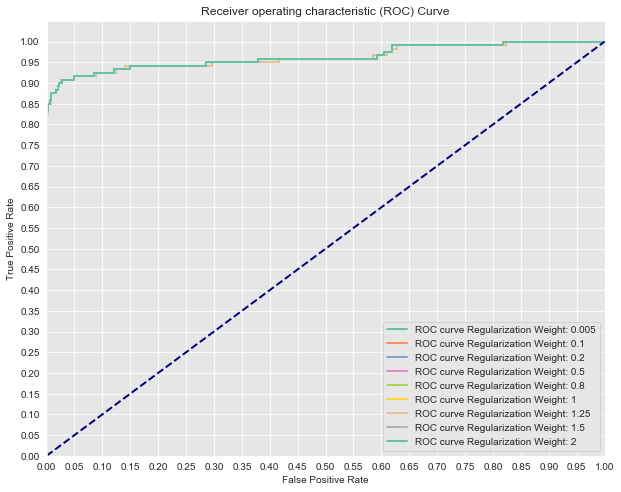

In [38]:
# try with resampled data
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")

## Analysis
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
1    284315
0    284315
dtype: int64


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.005: 0.9911817367166987


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.1: 0.9911704186199338


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.2: 0.9911701175614497


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.3: 0.9911700229487244


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.5: 0.9911699362533816


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.6: 0.9911699113136258


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.7: 0.9911699018127662


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.8: 0.9911698980520093


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.9: 0.9911698899366918


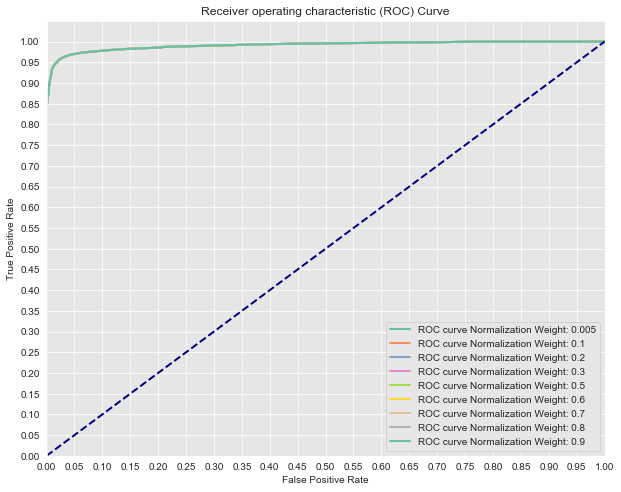

In [39]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Your response here
This line:
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 

resampled the entire dataset, including the test values. SMOTE should only be used on the training data. Testing should be done with original data. The graph shows better, but inaccurate, performance becuase of this.

## Summary

In this lab you got some hands on practice tuning logistic regression models using various techniques and parameters. In the upcoming labs and lessons we will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.